# SI 618 - Homework #7: Classifiers
or: How I Learned to Stop Worrying and Love Machine Learning

Version 2023.11.08.1.CT

This is, perhaps, one of the most exciting homework assignments that you have encountered in this course!

You are going to try your hand at a Kaggle competition to predict which passengers on board the Spaceship Titanic are transported to an alternate dimension.

You can access the competition here: **https://www.kaggle.com/c/spaceship-titanic**

This assignment is similar to the Kaggle competition that we did in class, but it uses a different and larger dataset.

The basic steps for this assignment are the same as what we did in class:

1. Accept the rules and join the competition
2. Download the data (from the data tab of the competition page)
3. Understand the problem
4. EDA (Exploratory Data Analysis)
5. Train, tune, and ensemble (!) your machine learning models
6. Upload your prediction as a submission on Kaggle and receive an accuracy score

additionally, you will

7. Upload your final notebook to Canvas and report your best accuracy score.  

Note that class grades are not entirely dependent on your accuracy score.  
All models that achieve 80% accuracy will receive full points for 
the accuracy component of this assignment.

Rubric:

1. (20 points) Conduct an EDA. You must demonstrate that you understand the data and the problem.
2. (60 points) Train, tune, and ensemble machine learning models.  You must use at least 3 different models, and you must ensemble them in some way.  You must also tune your models to improve accuracy.
4. (10 points) Accuracy score based on Kaggle submission report (or alternative, see NOTE above).
5. (10 points) PEP-8, grammar, spelling, style, etc.

Some additional notes:

1. If you use another notebook, code, or approaches be sure to reference the original work. (Note that we recommend you study existing Kaggle notebooks before starting your own work.)
2. You can help each other but in the end you must submit your own work, both to Kaggle and to Canvas.

Some additional resources:

* "ensemble" your models with a [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
* a good primer on [feature engineering](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)
* There are a lot of good [notebooks to study](https://www.kaggle.com/competitions/spaceship-titanic/code) (check the number of upvotes to help guide your exploration), but be careful to cite any code that you use, and be careful to not accidentally (or intentionally) cheat.

## GOOD LUCK!
(and don't cheat)

One final note:  Your submission should be a self-contained notebook that is NOT based
on this one.  Studying the existing Kaggle competition notebooks should 
give you a sense of what makes a "good" notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

### <span style="color:red">Loading the data & performing EDA - </span>

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
sample = pd.read_csv('sample_submission.csv')

In [4]:
train.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8621,9197_02,Europa,False,C/308/P,NaN,41.0,True,0.0,7964.0,0.0,3238.0,5839.0,Aludram Platch,False
4328,4611_01,Earth,True,G/754/S,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Ronard Hickson,True
6588,6951_01,Europa,False,D/219/P,TRAPPIST-1e,37.0,False,26.0,2898.0,9.0,0.0,40.0,Vegas Lendly,True
3882,4167_01,Earth,False,NaN,PSO J318.5-22,NaN,NaN,0.0,440.0,0.0,0.0,334.0,Ninaha Deckerson,False
5100,5450_01,Earth,True,G/877/P,PSO J318.5-22,16.0,False,0.0,0.0,0.0,0.0,0.0,Samany Keithunts,True


In [5]:
# Determining which fields are categorical and which are numerical
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [6]:
# Checking for duplicates
train.duplicated().sum()

0

In [7]:
#Checking for null values
train.isna().any()

PassengerId     False
HomePlanet       True
CryoSleep        True
Cabin            True
Destination      True
Age              True
VIP              True
RoomService      True
FoodCourt        True
ShoppingMall     True
Spa              True
VRDeck           True
Name             True
Transported     False
dtype: bool

In [8]:
# Splitting the 'Cabin' column into 'Deck', 'CabinNum', 'Side' in Train data
train[["Deck", "CabinNum", "Side"]] = train["Cabin"].str.split("/", expand=True)
train.drop('Cabin', axis=1, inplace=True)

In [9]:
# Splitting the 'Cabin' column into 'Deck', 'CabinNum', 'Side' in Test Data
test[["Deck", "CabinNum", "Side"]] = test["Cabin"].str.split("/", expand=True)
test.drop('Cabin', axis=1, inplace=True)

In [10]:
train.sample(5)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinNum,Side
6494,6857_01,Earth,False,PSO J318.5-22,35.0,False,22.0,0.0,1179.0,0.0,33.0,Jenn Jenson,False,F,1310,S
5031,5378_01,Europa,False,TRAPPIST-1e,30.0,False,0.0,95.0,0.0,1202.0,5558.0,Cellum Alenter,False,C,173,P
6768,7148_01,Europa,False,55 Cancri e,51.0,True,0.0,287.0,0.0,1442.0,66.0,Ranark Patimonne,True,A,87,S
3962,4223_02,Mars,False,55 Cancri e,24.0,False,469.0,0.0,NaN,196.0,0.0,Dous Grean,True,E,275,S
6335,6706_01,Europa,True,TRAPPIST-1e,21.0,False,0.0,0.0,0.0,0.0,0.0,Asellah Dishocatal,True,B,224,P


In [11]:
test.sample(5)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,CabinNum,Side
3353,7348_02,Mars,True,55 Cancri e,0.0,False,0.0,0.0,0.0,0.0,0.0,Pebix Coune,F,1414,S
3122,6838_03,Europa,False,55 Cancri e,34.0,False,695.0,2325.0,0.0,21.0,9626.0,Nekkard Fasticaly,C,217,P
1198,2525_01,Earth,False,TRAPPIST-1e,15.0,False,756.0,3.0,43.0,30.0,45.0,Lloyde Mayson,F,486,S
2714,5966_01,Earth,False,55 Cancri e,0.0,False,0.0,0.0,0.0,0.0,0.0,Loisey Monsoney,G,971,S
732,1495_01,Earth,False,TRAPPIST-1e,21.0,False,0.0,0.0,18.0,758.0,0.0,Wenise Dukertyler,NaN,NaN,NaN


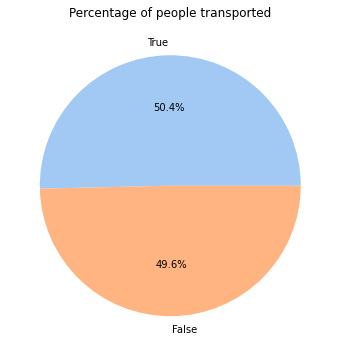

In [12]:
#Finding the percentage of people transported
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(8, 6))
transported_counts = train["Transported"].value_counts()
colors = sns.color_palette('pastel')[0:len(transported_counts)]

plt.pie(transported_counts,
        labels=transported_counts.keys(),
        autopct="%1.1f%%",
        colors=colors)
plt.title("Percentage of people transported")
plt.show()

### <span style="color:red">Pie Chart Interpretation - </span>
* The pie chart depicts a nearly even split between two categories with respect to the percentage of people transported. The "True" category is slightly larger, representing 50.4% of the pie, while the "False" category constitutes a marginally smaller share at 49.6%. This close distribution suggests that the number of people transported is roughly equivalent to those not transported 

Text(0.5, 1.0, 'Age Feature Distribution')

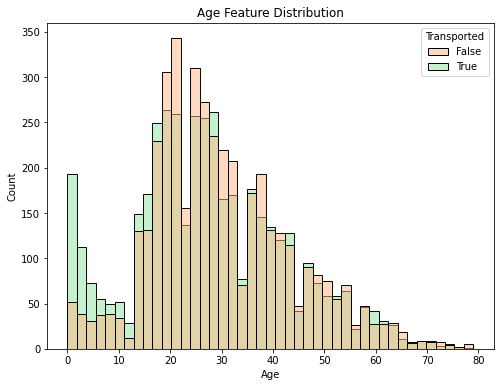

In [13]:
#Distribution of passengers based on their age
plt.figure(figsize=(8, 6))
sns.histplot(x=train["Age"],
             hue="Transported",
             data=train,
             palette=sns.color_palette('pastel')[1:3])
plt.title("Age Feature Distribution")

### <span style="color:red">Plot Interpretation - </span>
* The age distribution of individuals is skewed towards younger ages for both "True" and "False" categories, with a peak around the age of 20-30 years.
* The count of individuals decreases steadily as age increases for both categories.
* There's a noticeable overlap between the two categories, suggesting that the age distribution is somewhat similar for both.
* The "True" category consistently has a higher count across most age ranges, which might suggest that people being transported is more common in this dataset.
* There are some age ranges where the "False" category appears to have a slightly higher count, but these are fewer and generally involve lower counts of individuals.

<AxesSubplot:>

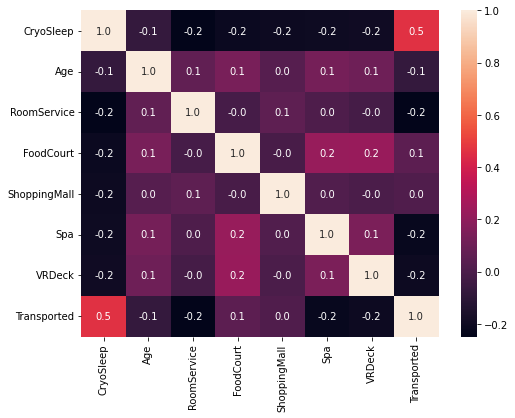

In [14]:
plt.figure(figsize=(8, 6))
train_corr = train[['CryoSleep','Age', 'RoomService',
                'FoodCourt', 'ShoppingMall', 'Spa', 
                'VRDeck', 'Transported']].dropna().corr()

sns.heatmap(data=train_corr, annot=True, fmt=".1f")

### <span style="color:red">Heatmap Interpretation - </span>
* 'CryoSleep' has a positive correlation (0.5) with being 'Transported', which is the strongest correlation observed in this heatmap. This suggests that there is a moderate positive relationship between individuals who are in cryosleep and their likelihood of being transported.
* All other features ('Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck') have very low correlation values with 'Transported', most of which are negative, though these values are so close to 0 they suggest virtually no linear relationship.
* 'Age' has a slight negative correlation with 'CryoSleep' (-0.1), suggesting younger people may be slightly more likely to be in cryosleep.
* Leisure and amenity features ('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck') have positive correlations with each other, generally around 0.1 to 0.2, indicating that individuals who use one of these services are slightly more likely to use the others.
* No feature shows a strong correlation with any other, as all the values are well below 0.5 in absolute value, indicating that there is no strong linear relationship between the features represented in this heatmap.

<AxesSubplot:xlabel='Destination', ylabel='count'>

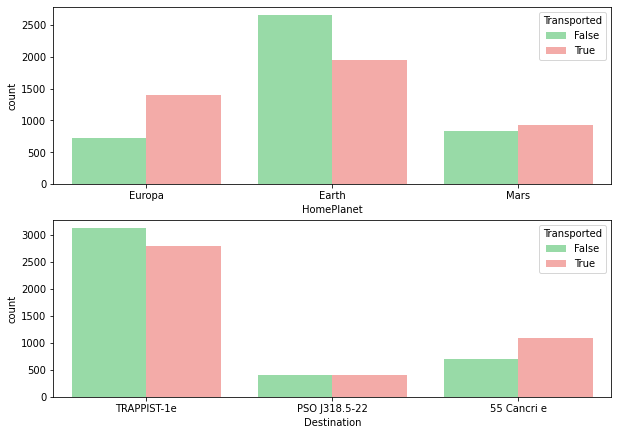

In [15]:
#Distribution of people who were transported based on their home planet and the destination planet

plt.figure(figsize=(10, 15))

plt.subplot(4, 1, 1)
sns.countplot(x='HomePlanet', hue='Transported', data=train, palette=sns.color_palette('pastel')[2:4])

plt.subplot(4, 1, 2)
sns.countplot(x='Destination', hue='Transported', data=train, palette=sns.color_palette('pastel')[2:4])

### <span style="color:red">Plot Interpretation - </span>
* Earth has the highest number of individuals transported ('True') compared to Europa and Mars.
* For Europa, the number of individuals not transported ('False') is higher than those who were transported.
* In contrast, on Mars, the number of individuals transported ('True') is lower than those not transported, but the difference is not as stark as it is for Europa.
* The total number of individuals (whether transported or not) from Earth is the highest among the three, indicating that Earth may have a larger population or that more individuals from Earth were involved in the scenario being measured.
* TRAPPIST-1e has the highest number of individuals who were successfully transported compared to PSO J318.5-22 and 55 Cancri e.
* The number of individuals not transported to TRAPPIST-1e is significant but still lower than the number that was transported.
* PSO J318.5-22 has a much smaller number of individuals related to it, with a slightly higher count of individuals not transported.
* For 55 Cancri e, the counts for transported and not transported are similar, but with a slightly higher number not transported.

### <span style="color:red">Preprocessing the data - </span>

In [16]:
# Separate categorical and numerical columns
numerical_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Age']
categorical_cols = ['CryoSleep','Deck','Side','VIP','HomePlanet','Destination']
transported=['Transported']

# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='mean')),  # Imputation transformer for completing missing values using the mean
    ('scaler', StandardScaler())  # Standardize features by removing the mean and scaling to unit variance
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),  # Imputation transformer for completing missing values using the most frequent value
    ('onehot', OneHotEncoder(sparse_output=False))  # Transform categorical data into one-hot vectors
])

# Combining numeric and categorical transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),  # Apply numeric_transformer to numeric columns
        ('cat', categorical_transformer, categorical_cols)  # Apply categorical_transformer to categorical columns
    ]
)



In [17]:
X=train.drop('Transported', axis=1)
y=train['Transported']
X_transformed=preprocessor.fit_transform(X)

In [18]:
test_transformed=preprocessor.transform(test)

In [19]:
X.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Deck             object
CabinNum         object
Side             object
dtype: object

### <span style="color:red">Model Training - </span>

Models Used - 
* Random Forest Classifier
* Support Vector Classifier
* XG Boost Classifier

Voting type in Coting Classifier - Soft

In [20]:
# Define classifiers
rf_classifier = RandomForestClassifier()
svm_classifier = SVC(probability=True)
xgb_classifier = XGBClassifier()

# Define parameter grids for grid search
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
svm_param_grid = {'C': [1, 10, 100], 'kernel': ['linear', 'rbf']}
xgb_param_grid = {'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [50, 100, 200]}

# Perform grid search for each classifier
rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=5)
svm_grid_search = GridSearchCV(svm_classifier, svm_param_grid, cv=5)
xgb_grid_search = GridSearchCV(xgb_classifier, xgb_param_grid, cv=5)

# Fit the grid search models
rf_grid_search.fit(X_transformed, y)
svm_grid_search.fit(X_transformed, y)
xgb_grid_search.fit(X_transformed, y)

# Get the best models from grid search
best_rf_model = rf_grid_search.best_estimator_
best_svm_model = svm_grid_search.best_estimator_
best_xgb_model = xgb_grid_search.best_estimator_

# Create a voting classifier with the best models
voting_classifier = VotingClassifier(estimators=[
    ('rf', best_rf_model),
    ('svm', best_svm_model),
    ('xgb', best_xgb_model)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

# Fit the voting classifier on the training data
y_pred = voting_classifier.fit(X_transformed, y)

# Evaluate the accuracy
accuracy = accuracy_score(y, voting_classifier.predict(X_transformed))
print(f'Ensemble Training Accuracy: {accuracy:.4f}')


Ensemble Training Accuracy: 0.8271


In [21]:
def get_score(model,X,y):
    n = cross_val_score(model,X,y,scoring ='accuracy',cv=20)
    return n

params_XGB_best ={'lambda': 3.0610042624477543, 
             'alpha': 4.581902571574289, 
             'colsample_bytree': 0.9241969052729379, 
             'subsample': 0.9527591724824661, 
             'learning_rate': 0.06672065863100594, 
             'n_estimators': 725,
             'max_depth': 5, 
             'min_child_weight': 1, 
             'num_parallel_tree': 1}

In [22]:
print(get_score(XGBClassifier(**params_XGB_best),X_transformed,y).mean())

0.8022577996715927


In [23]:
pred_XGB_best = (XGBClassifier(**params_XGB_best).fit(X_transformed,y)).predict(test_transformed)
sample['Transported'] = pred_XGB_best
sample['Transported']=sample['Transported']>0.5
sample.to_csv('Sudhanshu_Agarwal_Submission.csv', index=False)

### <span style="color:red">Final Accuracy on Kaggle - 0.80079 (80.079%)</span>

![Final Accuracy Snapshot](https://github-production-user-asset-6210df.s3.amazonaws.com/62510908/283535415-aa939fe9-0a16-4e6b-9df5-e632481cfaec.png)
